In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization, LayerNormalization, Reshape, Permute, Bidirectional, Add, Attention, Flatten, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Layer, Concatenate
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score
import librosa
import soundfile as sf
import noisereduce as nr
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt

2025-02-11 20:21:22.150269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 20:21:22.215882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739285482.257824  123761 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739285482.268667  123761 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 20:21:22.345006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Force GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU devices found")

In [3]:
# Data augmentation and preprocessing
def load_and_preprocess_audio(file_path, sr=16000, duration=4):
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Data Augmentation (increased probability and variety)
        if np.random.random() < 0.5:  # 50% chance of applying augmentation
            augmentation_type = np.random.choice(['noise', 'pitch', 'speed'])
            if augmentation_type == 'noise':
                noise = np.random.randn(len(audio)) * 0.005
                audio = audio + noise
            elif augmentation_type == 'pitch':
                audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.uniform(-2, 2))
            else:  # speed
                audio = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))

        # Normalize audio
        audio = audio - np.mean(audio)
        audio = audio / np.max(np.abs(audio))

        # Pad if necessary
        if len(audio) < sr * duration:
            audio = np.pad(audio, (0, sr * duration - len(audio)))
        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

In [4]:
def extract_features(audio, sr=16000, n_mels=80, n_fft=2048, hop_length=512):
    if audio is None:
        return None

    # Extract mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize features
    log_mel_spec = (log_mel_spec - np.mean(log_mel_spec)) / np.std(log_mel_spec)
    return log_mel_spec

In [5]:
# Analyze class distribution for debugging class imbalance
def analyze_class_distribution(data_path):
    real_count = len([f for f in os.listdir(os.path.join(data_path, 'real')) if f.endswith('.wav')])
    fake_count = len([f for f in os.listdir(os.path.join(data_path, 'fake')) if f.endswith('.wav')])
    total = real_count + fake_count
    print(f"\nClass Distribution for {data_path}:")
    print(f"Real: {real_count} ({real_count/total*100:.2f}%)")
    print(f"Fake: {fake_count} ({fake_count/total*100:.2f}%)")
    return {'real': real_count, 'fake': fake_count}


In [6]:
# Data generator with sample weights and debugging utilities
def data_generator(data_path, batch_size=32, shuffle=True):
    real_files = [os.path.join(data_path, 'real', f) for f in os.listdir(os.path.join(data_path, 'real')) if f.endswith('.wav')]
    fake_files = [os.path.join(data_path, 'fake', f) for f in os.listdir(os.path.join(data_path, 'fake')) if f.endswith('.wav')]
    
    all_files = real_files + fake_files
    labels = [1] * len(real_files) + [0] * len(fake_files)
    
    total_samples = len(all_files)
    class_weights = {
        1: total_samples / (2 * len(real_files)),
        0: total_samples / (2 * len(fake_files))
    }
    
    while True:
        if shuffle:
            temp = list(zip(all_files, labels))
            np.random.shuffle(temp)
            all_files, labels = zip(*temp)
        
        for i in range(0, len(all_files), batch_size):
            batch_files = all_files[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            
            batch_x = []
            batch_y = []
            batch_weights = []
            max_length = 0
            
            for file_path, label in zip(batch_files, batch_labels):
                audio = load_and_preprocess_audio(file_path)
                features = extract_features(audio)
                
                if features is not None:
                    batch_x.append(features.T)
                    batch_y.append(label)
                    weight = class_weights[label]
                    batch_weights.append(weight)
                    max_length = max(max_length, features.T.shape[0])
            
            # Pad sequences to max_length
            padded_batch_x = []
            for x in batch_x:
                padded_x = np.pad(x, ((0, max_length - x.shape[0]), (0, 0)), mode='constant')
                padded_batch_x.append(padded_x)
            
            if padded_batch_x:
                yield np.array(padded_batch_x), np.array(batch_y), np.array(batch_weights)

In [7]:
class MFM(Layer):
    def __init__(self, **kwargs):
        super(MFM, self).__init__(**kwargs)

    def call(self, inputs):
        shape = tf.shape(inputs)
        return tf.reshape(tf.math.maximum(inputs[:,:,:shape[-1]//2], inputs[:,:,shape[-1]//2:]), (shape[0], shape[1], shape[-1]//2))

In [8]:
def create_enhanced_lc_grnn_model(input_shape):
    inputs = Input(shape=input_shape)

    x = BatchNormalization()(inputs)

    # Light Convolutional layers with increased regularization
    x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = MFM()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)

    x = Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = MFM()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)

    # Bidirectional GRU layers with residual connections and increased regularization
    for units in [64, 32]:
        gru = Bidirectional(GRU(units // 2, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.02)))
        gru_output = gru(x)
        gru_output = Dense(K.int_shape(x)[-1])(gru_output)
        x = Add()([x, gru_output])
        x = LayerNormalization()(x)
        x = Dropout(0.5)(x)

    # Attention mechanism
    attention = Attention()([x, x])
    x = Add()([x, attention])

    # Final GRU layer
    x = Bidirectional(GRU(16, kernel_regularizer=tf.keras.regularizers.l2(0.02)))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.5)(x)

    # Dense layers with increased regularization
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = Dropout(0.5)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [9]:
# Paths to data
train_data_path = 'SceneFake/train'
dev_data_path = 'SceneFake/dev'
eval_data_path = 'SceneFake/eval'

# Analyze class distribution
print("Training set class distribution:")
analyze_class_distribution(train_data_path)
analyze_class_distribution(dev_data_path)
analyze_class_distribution(eval_data_path)

Training set class distribution:

Class Distribution for SceneFake/train:
Real: 2525 (19.15%)
Fake: 10660 (80.85%)

Class Distribution for SceneFake/dev:
Real: 2548 (19.84%)
Fake: 10295 (80.16%)

Class Distribution for SceneFake/eval:
Real: 6334 (19.34%)
Fake: 26412 (80.66%)


{'real': 6334, 'fake': 26412}

In [10]:
def count_files(path):
    real_files = [f for f in os.listdir(os.path.join(path, 'real')) if f.endswith('.wav')]
    fake_files = [f for f in os.listdir(os.path.join(path, 'fake')) if f.endswith('.wav')]
    return len(real_files) + len(fake_files)

# Create generators
batch_size = 64  # Increased batch size
train_gen = data_generator(train_data_path, batch_size=batch_size)
dev_gen = data_generator(dev_data_path, batch_size=batch_size)
eval_gen = data_generator(eval_data_path, batch_size=batch_size)

# Calculate steps per epoch
train_samples_count = count_files(train_data_path)
dev_samples_count = count_files(dev_data_path)
eval_samples_count = count_files(eval_data_path)

steps_per_epoch = train_samples_count // batch_size
validation_steps = dev_samples_count // batch_size
eval_steps = eval_samples_count // batch_size

In [11]:
# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [12]:
# Create and compile the model
input_shape = (None, 80)
model = create_enhanced_lc_grnn_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

I0000 00:00:1739285485.447983  123761 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1916 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # Reduced number of epochs
    validation_data=dev_gen,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/50


I0000 00:00:1739285493.308550  124118 cuda_dnn.cc:529] Loaded cuDNN version 90300


206/206 ━━━━━━━━━━━━━━━━━━━━ 193s 911ms/step - accuracy: 0.5941 - auc: 0.5031 - loss: 6.2645 - val_accuracy: 0.1980 - val_auc: 0.4713 - val_loss: 2.7833 - learning_rate: 0.0010
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 181s 882ms/step - accuracy: 0.4831 - auc: 0.5042 - loss: 2.3577 - val_accuracy: 0.1988 - val_auc: 0.4721 - val_loss: 1.4226 - learning_rate: 0.0010
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 180s 878ms/step - accuracy: 0.4711 - auc: 0.5052 - loss: 1.2690 - val_accuracy: 0.6977 - val_auc: 0.6637 - val_loss: 0.9518 - learning_rate: 0.0010
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 181s 881ms/step - accuracy: 0.6001 - auc: 0.6730 - loss: 0.8573 - val_accuracy: 0.7489 - val_auc: 0.7881 - val_loss: 0.8890 - learning_rate: 0.0010
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 175s 852ms/step - accuracy: 0.8026 - auc: 0.8956 - loss: 0.5833 - val_accuracy: 0.8476 - val_auc: 0.9144 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 174s 848ms/step - accuracy: 0.9

In [14]:
# Evaluate the model
print("\nEvaluating on Evaluation Dataset:")
eval_results = model.evaluate(eval_gen, steps=eval_steps)
print(f"Evaluation Results - Loss: {eval_results[0]}, Accuracy: {eval_results[1]}, AUC: {eval_results[2]}")


Evaluating on Evaluation Dataset:
511/511 ━━━━━━━━━━━━━━━━━━━━ 253s 495ms/step - accuracy: 0.9405 - auc: 0.9379 - loss: 0.5208
Evaluation Results - Loss: 0.5151093006134033, Accuracy: 0.9409246444702148, AUC: 0.937026858329773


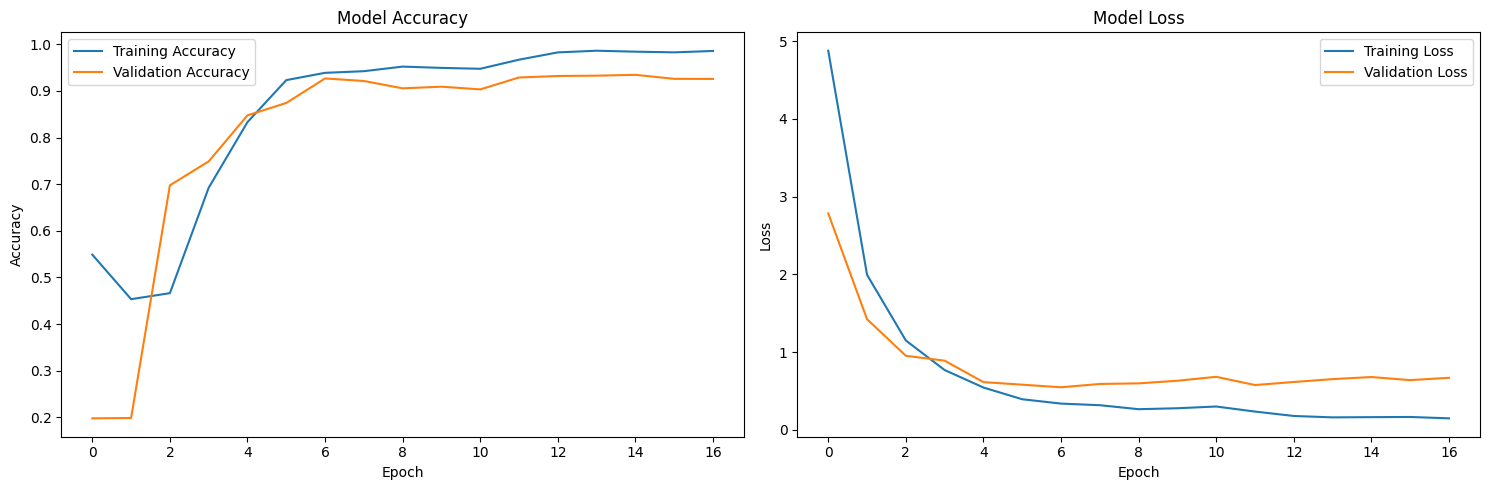

In [15]:
# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


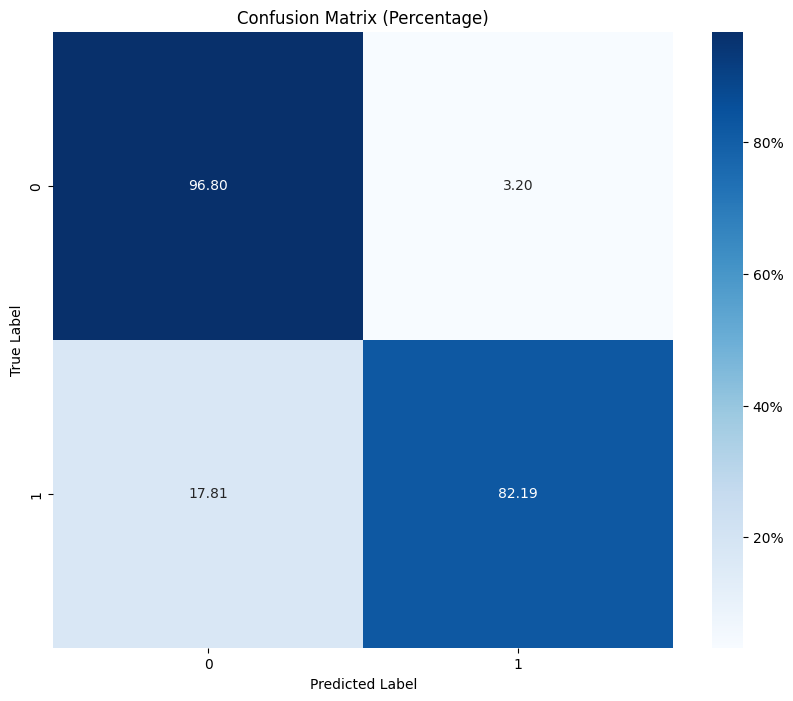

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# EER and t-DCF related imports
from scipy.interpolate import interp1d

# Define t-DCF parameters (these should be set according to your task)
p_target = 0.05  # Prior probability of target speaker
c_miss = 1       # Cost of a miss (false negative)
c_false_alarm = 1 # Cost of a false alarm (false positive)

# Reset the generator to its initial state
eval_gen = data_generator(eval_data_path, batch_size=batch_size)

# Generate predictions and collect true labels
y_pred = []
y_true = []
for _ in range(eval_steps):
    batch_x, batch_y, _ = next(eval_gen)
    batch_pred = model.predict(batch_x, verbose=0)
    y_pred.extend(batch_pred.flatten())
    y_true.extend(batch_y)

# Convert to numpy arrays and ensure same length
y_pred = np.array(y_pred)
y_true = np.array(y_true)
min_len = min(len(y_pred), len(y_true))
y_pred = y_pred[:min_len]
y_true = y_true[:min_len]

# Convert predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)


# Calculate F1 Score
f1 = f1_score(y_true, y_pred_binary)
print(f"F1 Score: {f1:.4f}")


# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Convert confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualize confusion matrix as percentages
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
plt.title('Confusion Matrix (Percentage)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


#---------------------------------------------------------------
# EER Calculation
#---------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
# Find the EER threshold
eer_threshold = thresholds[np.argmin(np.abs(fpr - (1-tpr)))]

# Calculate EER
eer = fpr[np.argmin(np.abs(fpr - (1-tpr)))]

print(f"EER: {eer:.4f}")

#---------------------------------------------------------------
# t-DCF Calculation
#---------------------------------------------------------------
def calculate_t_dcf(y_true, y_pred, p_target, c_miss, c_false_alarm, threshold):
    """
    Calculates the tuned Detection Cost Function (t-DCF).
    """
    # Apply threshold to get binary predictions
    y_pred_binary = (y_pred >= threshold).astype(int)

    # Calculate confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

    # Calculate False Alarm Rate (FAR) and Miss Rate (FR)
    far = fp / (tn + fp)
    fr = fn / (tp + fn)

    # Calculate t-DCF
    t_dcf = c_miss * p_target * fr + c_false_alarm * (1 - p_target) * far

    return t_dcf

# Calculate t-DCF using the EER threshold
t_dcf = calculate_t_dcf(y_true, y_pred, p_target, c_miss, c_false_alarm, eer_threshold)
print(f"t-DCF: {t_dcf:.4f}")


In [18]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import noisereduce as nr
from scipy.signal import butter, sosfilt
import soundfile as sf

def denoise_and_amplify(audio, sr):
    try:
        # Noise Reduction
        reduced_noise = nr.reduce_noise(y=audio, sr=sr, stationary=False)
        return reduced_noise
    except Exception as e:
        print(f"Error in denoise_and_amplify: {e}")
        return audio  # Return original audio if an error occurs

def preprocess_and_visualize(file_path, sr=16000, duration=4):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=sr, duration=duration)
    
    # Save original audio
    sf.write('original_audio.wav', audio, sr)
    
    # Original Mel Spectrogram
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=80, n_fft=2048, hop_length=512)
    librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.title('Original Mel Spectrogram')
    
    # Noise Reduction using denoise_and_amplify function
    reduced_noise = denoise_and_amplify(audio, sr)
    sf.write('noise_reduced_audio.wav', reduced_noise, sr)
    
    # Final Mel Spectrogram
    plt.subplot(1, 3, 3)
    final_mel_spec = librosa.feature.melspectrogram(y=reduced_noise, sr=sr, n_mels=80, n_fft=2048, hop_length=512)
    librosa.display.specshow(librosa.power_to_db(final_mel_spec, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.title('Final Mel Spectrogram')
    
    plt.tight_layout()
    plt.savefig('mel_spectrograms.png')
    plt.close()

# Use the function
file_path = 'A_2582_0_A.wav'
preprocess_and_visualize(file_path)
